In [1]:
import pandas as pd
import backtrader as bt
from xgboost import XGBClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import logging


# Set up logging
logging.basicConfig(
    filename="backtest.log",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger()


In [2]:
class CustomDataFeeder:
    def __init__(self, data, start_date):
        """
        Initialize the data feeder.
        Args:
            data (pd.DataFrame): Daily stock data for multiple stocks.
            start_date (str or pd.Timestamp): Date from which to start the masking.
        """
        self.data = data.copy()
        self.data.sort_values(by=['timestamp', 'ticker'], inplace=True)
        # Precompute valid trading days (sorted list)
        self.trading_days = sorted(self.data['timestamp'].unique())

        # Ensure start_date is valid
        self.start_date = pd.to_datetime(start_date)
        self.current_index = self._find_trading_day_index(self.start_date)

        # Set the current date to the determined trading day
        self.current_date = self.trading_days[self.current_index]
        self.last_date = self.trading_days[-1]

    def _find_trading_day_index(self, date):
        """
        Find the index of the closest later trading day.
        Args:
            date (pd.Timestamp): The date to align with a trading day.
        Returns:
            int: Index of the closest trading day.
        """
        for idx, trading_day in enumerate(self.trading_days):
            if trading_day >= date:
                return idx
        raise ValueError(f"No trading days available after {date}.")

        
    def get_data(self):
        """
        Get the current slice of data up to the current date.
        Returns:
            pd.DataFrame: Data visible up to the current date.
        """
        visible_data = self.data[self.data['timestamp'] <= self.current_date]
        return visible_data
    
    def next(self):
        """
        Move the masking window to the next trading day.
        Raises:
            ValueError: If attempting to move beyond the last available date.
        """
        if self.current_index + 1 >= len(self.trading_days):
            raise ValueError(
                f"Cannot move forward. Current date {self.current_date.date()} "
                f"is already the last trading day {self.last_date.date()} in the dataset."
            )
        # Increment the index to the next trading day
        self.current_index += 1
        self.current_date = self.trading_days[self.current_index]


    def reset(self):
        """
        Reset the masking window to the start date.
        """
        self.current_date = self.start_date
        self.current_index = self._find_trading_day_index(self.start_date)

    def last_day(self):
        """
        Check if last day has been reached
        """
        return self.current_date >= self.last_date


In [3]:
class Portfolio:
    def __init__(self, initial_cash):
        """
        Initialize the portfolio.
        Args:
            initial_cash (float): Starting cash for the backtest.
        """
        self.cash = initial_cash
        self.positions = []  # List to store open positions
        self.balance_history = []  # Track daily balance

    def add_position(self, ticker, price, quantity, date):
        """
        Add a new position to the portfolio.
        Args:
            ticker (str): Stock ticker.
            price (float): Buy price per share.
            quantity (int): Number of shares.
            date (pd.Timestamp): Date of purchase.
        """
        total_cost = price * quantity
        if self.cash >= total_cost:
            self.cash -= total_cost
            self.positions.append({"ticker": ticker, "price": price, "quantity": quantity, "date": date})
            logger.info(
                f"Position opened: Date={date}, Ticker={ticker}, Buy Price={price}, "
                f"Quantity={quantity}, Total Amount={total_cost}"
            )
            print(f"Position opened: {date} - {ticker} - Price: {price}, Quantity: {quantity}, Total: {total_cost}")
        

    def close_position(self, ticker, price, date):
        """
        Close a position in the portfolio.
        Args:
            ticker (str): Stock ticker to close.
            price (float): Sell price per share.
            date (pd.Timestamp): Date of sale.
        """
        for position in self.positions:
            print(f"trying to close position", position)
            if position["ticker"] == ticker:
                # Calculate profit/loss
                total_value = position["quantity"] * price
                self.cash += total_value
                self.positions.remove(position)
                return total_value - (position["quantity"] * position["price"])
                logger.info(
                    f"Position closed: Date={date}, Ticker={ticker}, Sell Price={price}, "
                    f"Quantity={position['quantity']}, Total Amount={total_value}, Profit/Loss={profit_or_loss}"
                )
                print(
                    f"Position closed: {date} - {ticker} - Sell Price: {price}, "
                    f"Quantity: {position['quantity']}, Total: {total_value}, P/L: {profit_or_loss}"
                )
        raise ValueError(f"No open position found for {ticker}.")

    def calculate_total_balance(self, current_prices):
        """
        Calculate total balance (cash + value of open positions).
        Args:
            current_prices (dict): Dictionary of current prices for all tickers.
        Returns:
            float: Total portfolio balance.
        """
        total_value = self.cash
        for position in self.positions:
            total_value += position["quantity"] * current_prices.get(position["ticker"], 0)
        return total_value

In [4]:
#This is a class that defines the allocation strategy if more than one stock returns a signal. 

from abc import ABC, abstractmethod

class PurchaseStrategy(ABC):
    @abstractmethod
    def make_purchases(self, portfolio, daily_data, buy_signals, current_date):
        """
        Execute purchase logic.
        Args:
            portfolio (Portfolio): The portfolio object to manage trades.
            daily_data (pd.DataFrame): The daily data for all stocks.
            buy_signals (pd.DataFrame): DataFrame containing tickers and buy confidence levels.
            current_date (pd.Timestamp): The current date of backtesting.
        """
        pass


class EqualAllocationStrategy(PurchaseStrategy):
    def make_purchases(self, portfolio, daily_data, buy_signals, current_date):
        # Determine the number of stocks to buy
        n_stocks = len(buy_signals)
        if n_stocks == 0:
            return
        
        # Allocate equal cash to each stock
        cash_per_stock = portfolio.cash / n_stocks
        
        for _, signal in buy_signals.iterrows():
            ticker = signal["ticker"]
            row = daily_data[daily_data["ticker"] == ticker].iloc[0]
            price = row["close"]
            quantity = int(cash_per_stock // price)  # Determine how many shares to buy
            
            if quantity > 0:
                portfolio.add_position(ticker, price, quantity, current_date)
            else:
                print(f"can't even buy one stock of {ticker}, price is {price}, cash_per_stock is {cash_per_stock}")


class ConfidenceWeightedStrategy(PurchaseStrategy):
    def make_purchases(self, portfolio, daily_data, buy_signals, current_date):
        # Calculate total confidence
        total_confidence = buy_signals["confidence"].sum()
        if total_confidence == 0:
            return
        
        for _, signal in buy_signals.iterrows():
            ticker = signal["ticker"]
            confidence = signal["confidence"]
            row = daily_data[daily_data["ticker"] == ticker].iloc[0]
            price = row["close"]
            
            # Allocate cash proportionally to confidence
            allocation = (confidence / total_confidence) * portfolio.cash
            quantity = int(allocation // price)  # Determine how many shares to buy
            
            if quantity > 0:
                portfolio.add_position(ticker, price, quantity, current_date)

In [5]:
class Backtester:
    def __init__(self, data_feeder, purchase_strategy, buy_model, sell_model=None, initial_cash=1000000):
        """
        Initialize the backtesting engine.
        Args:
            data_feeder (CustomDataFeeder): The data feeder object.
            buy_model (sklearn.base.BaseEstimator): Pre-trained model for buy decisions.
            sell_model (sklearn.base.BaseEstimator): Pre-trained model for sell decisions.
            initial_cash (float): Starting cash for the backtest.
        """
        self.data_feeder = data_feeder
        self.buy_model = buy_model
        self.sell_model = sell_model
        self.portfolio = Portfolio(initial_cash)
        self.purchase_strategy = purchase_strategy


    def should_open_position(self, row):
        """
        Decide whether to open a position for a given stock.
        Args:
            row (pd.Series): A row of data for a stock on the current day.
        Returns:
            dict or None: A dictionary containing the ticker and confidence if a buy signal is generated, None otherwise.
        """
        ticker = row["ticker"]
        features = row.drop(["timestamp", "ticker"]).values.reshape(1, -1)  # Prepare features
        confidence = self.buy_model.predict_proba(features)[0, 1]  # Predict confidence for buy

        if confidence > 0.5:  # Adjust threshold as needed
            logger.info(f"Buy signal: Date={row['timestamp']}, Ticker={ticker}")
            print(f"Buy signal: {row['timestamp']} - {ticker}")
            return {"ticker": ticker, "confidence": confidence}
        return None


    def should_close_position(self, position, visible_data, current_date):
        """
        Assess a position and decide whether to sell it.
        Args:
            position (dict): A dictionary containing details about the position.
            visible_data (pd.DataFrame): Data visible on the current date.
            current_date (pd.Timestamp): Current date in the backtest.
        Returns:
            bool: True if the position should be sold, False otherwise.
        """
        # Sell after holding for three days
        hold_days = (current_date - position["date"]).days
        if hold_days >= 10:
            logger.info(f"Sell signal: Date={current_date}, Ticker={position['ticker']}")
            print(f"Sell signal: {current_date} - {position['ticker']}")
            return True
        return False

    def run(self):
        """
        Run the backtesting loop.
        """
        while not self.data_feeder.last_day():
            # Get data for the current day
            visible_data = self.data_feeder.get_data()
            current_date = self.data_feeder.current_date

            # Extract only today's data
            todays_data = visible_data[visible_data['timestamp'] == current_date]

            # Extract current prices for balance calculation
            current_prices = todays_data.groupby("ticker")["close"].last().to_dict()

            # Check and close open positions
            for position in self.portfolio.positions[:]:  # Iterate over a copy of the list
                ticker = position["ticker"]
                stock_data = todays_data[todays_data["ticker"] == ticker]
                if self.should_close_position(position, stock_data, current_date):
                    if ticker not in current_prices:
                        print(f"Ticker {ticker} not found in current_prices on {current_date}")
                        continue
                    self.portfolio.close_position(ticker, current_prices[ticker], current_date)

            # Make buy decisions
            buy_signals = []
            for _, row in todays_data.iterrows():
                buy_signal = self.should_open_position(row)
                if buy_signal:
                    buy_signals.append(buy_signal)
            logger.info(f"On {current_date}, we generated the following buy_signals: {buy_signals}")
            print(f"On {current_date}, we generated the following buy_signals: {buy_signals}")

            # Convert to DataFrame for easier handling
            buy_signals_df = pd.DataFrame(buy_signals)

            # Use the purchase strategy
            self.purchase_strategy.make_purchases(self.portfolio, todays_data, buy_signals_df, current_date)

            # Update portfolio balance history
            total_balance = self.portfolio.calculate_total_balance(current_prices)
            self.portfolio.balance_history.append({"date": current_date, "balance": total_balance})

            # Move to the next day
            logger.info(f"Today is: {current_date} - Open Positions: {self.portfolio.positions} - Total Balance: {total_balance}")
            print(f"Today is: {current_date} - Open Positions: {self.portfolio.positions} - Total Balance: {total_balance}")
            self.data_feeder.next()

        print("Backtest complete!")



To use this model, follow these steps: 
1. Load the data, and make sure the datatype and pre-processing steps are identical to what the model is trained on to avoid prediction errors
2. Defined a subclass of Purchase Strategy to act on how to divide money into each buy signals (the default one sucks)
3. Load the machine learning model that gives buy signals
4. Load the machine learning model that gives sell signals (we don't have one yet, currently using simply sell after 10 days)
5. Initiate data_feeder and specify a start_date to backtest from 
6. Pass data feeder, allocation strategy, buy signal model, sell signal model, and initial cash and run it

In [6]:
from tqdm import tqdm

##########################################
# Step 1: load the data and pre-process
##########################################

df = pd.read_csv('combined_data_with_y_ta.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.sort_values(by=['timestamp', 'ticker'], inplace=True)
X = df.copy().drop(columns='y')
y = df['y']

timestamp_column = df[['timestamp', 'ticker']]
numeric_columns = df.drop(columns=["timestamp", "ticker"])

# Create a new DataFrame with scaled data
scaled_numeric_df = pd.DataFrame(X, columns=numeric_columns.columns, index=numeric_columns.index)

# Add the timestamp column back
final_df = pd.concat([timestamp_column, scaled_numeric_df], axis=1)


##########################################
# Step 2: Implement an allocation strategy
##########################################
purchase_strategy = EqualAllocationStrategy()

##########################################
# Step 3: Load the model(s)
##########################################

model = XGBClassifier()
model.load_model('first_xgb.json')


##########################################
# Step 4: Implement an allocation strategy
##########################################
#Codes here


##########################################
# Step 5: Implement an allocation strategy
##########################################
data_feeder = CustomDataFeeder(final_df, start_date = '2024-09-01')
data_feeder.reset()


##########################################
# Step 6: Initiate backtester and run
##########################################
backtester = Backtester(data_feeder, purchase_strategy, model)

backtester.run()
# Run the backtesting loop with tqdm progress bar
total_days = len(data_feeder.trading_days) - data_feeder.current_index
for _ in range(total_days):
    backtester.run()

On 2024-09-01 00:00:00, we generated the following buy_signals: []
Today is: 2024-09-01 00:00:00 - Open Positions: [] - Total Balance: 1000000
Buy signal: 2024-09-03 00:00:00 - 8
Buy signal: 2024-09-03 00:00:00 - 10
Buy signal: 2024-09-03 00:00:00 - 12
Buy signal: 2024-09-03 00:00:00 - 31
Buy signal: 2024-09-03 00:00:00 - 36
Buy signal: 2024-09-03 00:00:00 - 40
Buy signal: 2024-09-03 00:00:00 - 55
Buy signal: 2024-09-03 00:00:00 - 56
Buy signal: 2024-09-03 00:00:00 - 60
Buy signal: 2024-09-03 00:00:00 - 61
Buy signal: 2024-09-03 00:00:00 - 69
Buy signal: 2024-09-03 00:00:00 - 78
Buy signal: 2024-09-03 00:00:00 - 100
Buy signal: 2024-09-03 00:00:00 - 166
Buy signal: 2024-09-03 00:00:00 - 401
Buy signal: 2024-09-03 00:00:00 - 407
Buy signal: 2024-09-03 00:00:00 - 413
Buy signal: 2024-09-03 00:00:00 - 417
Buy signal: 2024-09-03 00:00:00 - 419
Buy signal: 2024-09-03 00:00:00 - 428
Buy signal: 2024-09-03 00:00:00 - 430
Buy signal: 2024-09-03 00:00:00 - 488
Buy signal: 2024-09-03 00:00:00 - 

In [7]:
balance_history_df = pd.DataFrame(backtester.portfolio.balance_history)

Final Balance: $1,083,993.71
Total Return: 8.40%
Annualized Return: 230.54%
Volatility: 25.03%
Sharpe Ratio: 9.21
Best Performing Stock: 300072.0 with P/L: $650.88
Worst Performing Stock: 600070.0 with P/L: $-47.84


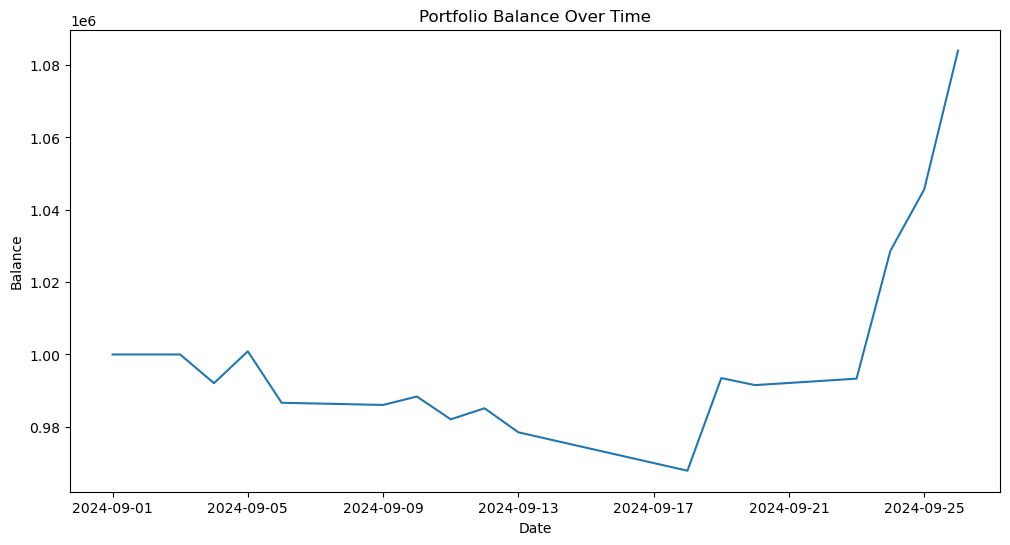

In [ ]:
import matplotlib.pyplot as plt

# Calculate performance metrics
initial_cash = 1000000
final_balance = backtester.portfolio.balance_history[-1]['balance']
total_return = (final_balance - initial_cash) / initial_cash * 100
annualized_return = ((1 + total_return / 100) ** (252 / len(backtester.portfolio.balance_history)) - 1) * 100

# Calculate daily returns
balance_history_df = pd.DataFrame(backtester.portfolio.balance_history)
balance_history_df['daily_return'] = balance_history_df['balance'].pct_change()

# Calculate volatility (standard deviation of daily returns)
volatility = balance_history_df['daily_return'].std() * (252 ** 0.5) * 100

# Calculate Sharpe ratio (assuming risk-free rate is 0)
sharpe_ratio = (annualized_return - 0) / volatility

# Generate report
print(f"Final Balance: ${final_balance:,.2f}")
print(f"Total Return: {total_return:.2f}%")
print(f"Annualized Return: {annualized_return:.2f}%")
print(f"Volatility: {volatility:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Extract current prices from the last day of backtesting
current_prices = backtester.data_feeder.get_data().groupby("ticker")["close"].last().to_dict()

# Analyze positions
positions_df = pd.DataFrame(backtester.portfolio.positions)
positions_df['return'] = positions_df.apply(lambda row: (row['quantity'] * row['price']), axis=1)
positions_df['current_value'] = positions_df.apply(lambda row: (row['quantity'] * current_prices.get(row['ticker'], 0)), axis=1)
positions_df['profit_loss'] = positions_df['current_value'] - positions_df['return']

# Find the best and worst performing stocks
best_stock = positions_df.loc[positions_df['profit_loss'].idxmax()]
worst_stock = positions_df.loc[positions_df['profit_loss'].idxmin()]

print(f"Best Performing Stock: {best_stock['ticker']} with P/L: ${best_stock['profit_loss']:,.2f}")
print(f"Worst Performing Stock: {worst_stock['ticker']} with P/L: ${worst_stock['profit_loss']:,.2f}")

# Plot balance history
plt.figure(figsize=(12, 6))
plt.plot(balance_history_df['date'], balance_history_df['balance'])
plt.xlabel('Date')
plt.ylabel('Balance')
plt.title('Portfolio Balance Over Time')
plt.show()